In [1]:
import os
import sys
import pickle
import random
import warnings
warnings.filterwarnings("ignore")

# add the path of packages to system path
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# add packages for computation
import numpy as np
import pandas as pd
import marketmodel.loader as loader
import marketmodel.utils as utils

from marketmodel.factors import PrepTrainData, DecodeFactor
from marketmodel.loader import DataHestonSlv
from marketmodel.neuralsde import Train, Simulate, Model

# load configurations
hp_model_S = utils.Config.hp_model_S
hp_model_mu = utils.Config.hp_model_mu
hp_model_xi = utils.Config.hp_model_xi
hp_sde_transform = utils.Config.hp_sde_transform

# set paths
hestonslv_fname = '../input/sim_hestonslv.pkl'
checkpoint_model_S_initial = '../output/checkpoint/initial_model_S/model_S_0'
dir_mdl = '../output/checkpoint/train_paper/'
checkpoint_model_S = dir_mdl + 'model_S'
checkpoint_model_mu = dir_mdl + 'model_mu'
checkpoint_model_xi = dir_mdl + 'model_xi'
sim_fname = dir_mdl + 'sim.csv'

# Load, pre-process data and decode factors

In [2]:
# load Heston-SLV simulation data
St, vt, list_exp, list_mny, cs_ts_raw, cs_ts, mask_quality_value, \
Ts, ks, mat_A, vec_b = loader.load_hestonslv_data(hestonslv_fname)

# load the trained initial model for S
X_S, Y_S = PrepTrainData.prep_data_model_S_initial(
    St, cs_ts, max_PC=7, factor_multiplier=1e5)

model_S_initial = Model.construct_S(X_S.shape[1], X_S.shape[0], 
                                    hp_model_S['pruning_sparsity'],
                                    hp_model_S['validation_split'],
                                    hp_model_S['batch_size'],
                                    hp_model_S['epochs'])
model_S_initial.load_weights(checkpoint_model_S_initial)

# calculate derivatives for the normalised call prices
cT_ts, cm_ts, cmm_ts = PrepTrainData.calc_call_derivatives(
    list_mny, list_exp, cs_ts_raw, mask_quality_value)

G, X, dX, S, dS, W, b, idxs_remove, scales_X = DecodeFactor.decode_factor_dasa(
    cs_ts, St, model_S_initial, X_S, cT_ts, cm_ts, cmm_ts, mat_A, vec_b, 
    hp_sde_transform['norm_factor'])

cT_ts = np.delete(cT_ts, idxs_remove, axis=0)
cm_ts = np.delete(cm_ts, idxs_remove, axis=0)
cmm_ts = np.delete(cmm_ts, idxs_remove, axis=0)

Instructions for updating:
Please use `layer.add_weight` method instead.


100%|██████████| 66/66 [00:00<00:00, 2469.77it/s]


# Load trained models

In [3]:
n_obs, n_dim = X.shape
n_varcov = int(n_dim*(n_dim+1)/2)

# load the model for S
X_S, Y_S = PrepTrainData.prep_data_model_S(S, dS, X, hp_model_xi['factor_multiplier'])

model_S = Model.construct_S(X_S.shape[1], X_S.shape[0], 
                            hp_model_S['pruning_sparsity'],
                            hp_model_S['validation_split'],
                            hp_model_S['batch_size'],
                            hp_model_S['epochs'])
model_S.load_weights(checkpoint_model_S)

# load the model for mu
model_mu = Model.construct_mu(X_S.shape[1])
model_mu.load_weights(checkpoint_model_mu)

# load the model for xi
model_xi = Model.construct_xi(n_dim + 1, n_dim + n_varcov, n_obs,
                              hp_model_xi['pruning_sparsity'],
                              hp_model_xi['validation_split'],
                              hp_model_xi['batch_size'],
                              hp_model_xi['epochs'])
model_xi.load_weights(checkpoint_model_xi)

# In-sample test

## In-sample prediction 

In [4]:
# calibrate a hypterparameter for normalising distance
dist_X = np.abs(W.dot(X.T) - b[:, None]) / \
         np.linalg.norm(W, axis=1, keepdims=True)
critical_threshold = hp_sde_transform['frac_critical_threshold'] * np.min(
    np.max(dist_X, axis=1))
dist_multiplier = (1. / (
        1 - hp_sde_transform['critical_value']) - 1) / critical_threshold

# pre-calculate diffusion scaling data
proj_scale = hp_sde_transform['proj_scale']
Omegas, det_Omega, proj_dX = PrepTrainData.calc_diffusion_scaling(
    W, b, X, dX, dist_multiplier, proj_scale)

# pre-calculate drift correction data
X_interior, corr_dirs, epsmu = PrepTrainData.calc_drift_correction(
    W, b, X, hp_sde_transform['rho_star'], hp_sde_transform['epsmu_star'])

# prepare training data for the model of xi
mu_base_est = model_mu.predict(X_S)
z_ts = PrepTrainData.calc_zt(cT_ts, cm_ts, cmm_ts, model_S, X_S)
X_xi, Y_xi = PrepTrainData.prepare_data_model_xi(
    S, X, proj_dX, Omegas, det_Omega, corr_dirs, epsmu, mu_base_est, z_ts,
    hp_model_xi['factor_multiplier'])

# make in-sample prediction
mu_tilde, sigma_tilde_T, mu, sigma_T, sigma_L = Train.predict_in_sample_model_xi(
    model_xi, X_xi, Y_xi, W, G)

100%|██████████| 9951/9951 [00:01<00:00, 6183.66it/s]


## Comparison with the approximated groud-truth

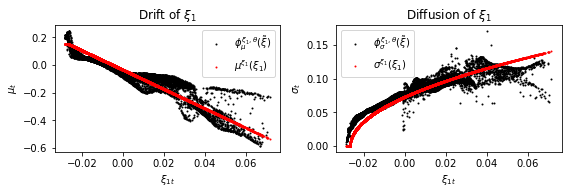

In [5]:
infile = open(hestonslv_fname, 'rb')
data_cache = pickle.load(infile)
infile.close()

utils.PlotLib.plot_in_sample_model_xi(vt, idxs_remove, X, data_cache, mu, sigma_L)

## Visualisation of NN-modelled drift and diffusion

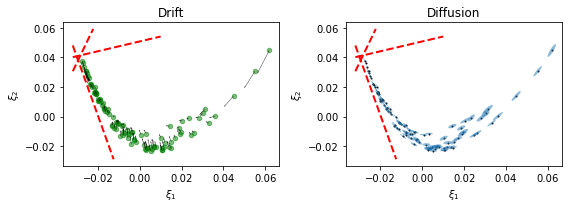

In [6]:
np.random.seed(0)
n_plot_points = 100
utils.PlotLib.plot_xi_drift_diffusion(X, mu, sigma_L, n_plot_points, W, b)

# Forward simulation

## Load a sample saved simulation path

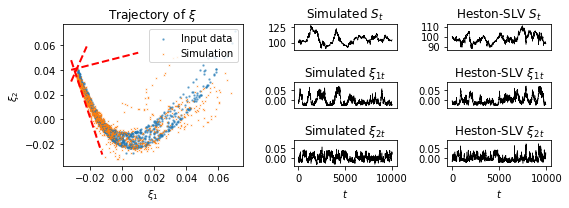

In [7]:
# load saved simulation results
data_fname = 'sim.csv'

df = pd.read_csv(sim_fname)
st = df['S'].values
xit = df[['xi1', 'xi2']].values.T

# plot simulated paths
utils.PlotLib.plot_simulated_paths(St, X, st, xit, W, b)

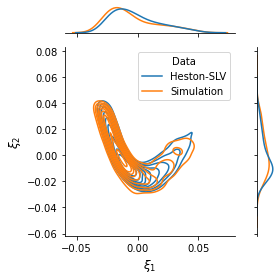

In [8]:
utils.PlotLib.plot_xi12(X, xit)

## Simulate multiple paths

Users could use the following code template to simulate multiple paths of various lengths and time increments.

In [9]:
n_sim = 10
N = 100
dt = 1e-3

S0 = S[0]
X0 = X[0, :]

ls_st = []
ls_xit = []

np.random.seed(0)
for i in range(n_sim):
    print(f'Simulate path {i}')
    st, xit, _, _, _ = Simulate.simulate_S_xi_lite(
        dt, N, model_S, model_xi, model_mu,
        S0, X0, W, b, hp_model_xi['factor_multiplier'],
        dist_multiplier, proj_scale,
        hp_sde_transform['rho_star'], hp_sde_transform['epsmu_star'],
        X_interior, reflect=True)
    
    ls_st.append(st)
    ls_xit.append(xit)

  1%|          | 1/100 [00:00<00:18,  5.41it/s]

Simulate path 0


  1%|          | 1/100 [00:00<00:14,  6.89it/s]

Simulate path 1


  0%|          | 0/100 [00:00<?, ?it/s]

Simulate path 2


  1%|          | 1/100 [00:00<00:16,  5.92it/s]

Simulate path 3


  1%|          | 1/100 [00:00<00:15,  6.25it/s]

Simulate path 4


  1%|          | 1/100 [00:00<00:14,  6.94it/s]

Simulate path 5


  1%|          | 1/100 [00:00<00:15,  6.57it/s]

Simulate path 6


  1%|          | 1/100 [00:00<00:14,  6.90it/s]

Simulate path 7


  1%|          | 1/100 [00:00<00:13,  7.32it/s]

Simulate path 8


  1%|          | 1/100 [00:00<00:13,  7.11it/s]

Simulate path 9


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


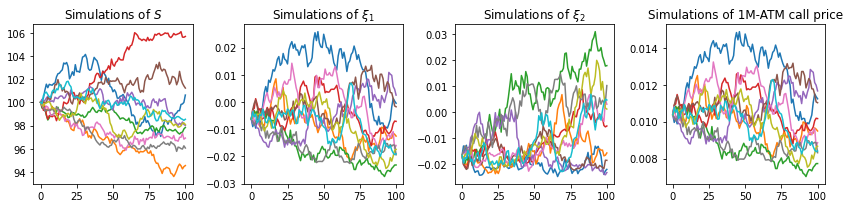

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,3))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
ax1.set_title(r'Simulations of $S$')
ax2.set_title(r'Simulations of $\xi_1$')
ax3.set_title(r'Simulations of $\xi_2$')
ax4.set_title(r'Simulations of 1M-ATM call price')
for i in range(n_sim):
    ax1.plot(ls_st[i])
    ax2.plot(ls_xit[i][0])
    ax3.plot(ls_xit[i][1])
    ax4.plot((G[1:].T.dot(ls_xit[i]) + G[0][:,None])[5])
plt.tight_layout()